# Experiment - ordering the SCOTUS justices

In this notebook, we want to investigate the Supreme Court Of The United States. It is the highest instance of the US, with 9 justices, nominated for life by successive presidents of the US. These justices rule out disputes - a few hundreds every year -, and we could use the data of their vote to order them on a left-right axis.

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd 
from tqdm import tqdm

import matplotlib.pylab as pl

In [2]:

import pylab as pl
import matplotlib
fm = matplotlib.font_manager
fm._get_fontconfig_fonts.cache_clear()
la = pl.matplotlib.font_manager.FontManager()
lu = pl.matplotlib.font_manager.FontProperties(family = 'Linux Libertine')
la.findfont(lu)

# set Linux libertine as font
plt.rcParams["font.family"] = "Linux Libertine"
plt.rcParams["font.size"] = 18

In [3]:
import axisrules as axis

We start by loading the data we gathered. This data contains:
* The list of the justices since 1946.
* For each term, justices are grouped according to their opinions (for instance, they joined the majority, a regular concurrence, special concurrence, or a dissent opinion). We consider each group as an approval ballot, and we skip all groups of length 1.

For example in the following, we show 10 such opinions. Note that every opinion of length $\ge 5$ is a majority opinion and everything else is either a dissent or a concurrence.

In [4]:
justice_names = json.load(open('data/justice_names.json'))
opinions_by_year = json.load(open('data/opinions_by_year.json'))
majority_opinions_by_year = json.load(open('data/majority_opinions_by_year.json'))
opinions_by_year["2021"][:10]

[[111, 108, 110, 112, 113, 114, 116, 117],
 [108, 117],
 [113, 115],
 [111, 108, 110, 112, 113, 114, 115, 116, 117],
 [111, 108, 112, 115, 116, 117],
 [110, 114],
 [113, 114],
 [111, 110, 112, 113, 114, 115, 116, 117],
 [116, 112],
 [111, 110, 116, 117]]

We quickly define a function that converts opinions to approval:

In [5]:
def opinion_to_approval(opinions, justice_id):
    approval_matrix = np.zeros((len(opinions),9))
    for i, case in enumerate(opinions):
        for j in case:
            approval_matrix[i,justice_id.index(j)] = 1

    return approval_matrix

opinion_to_approval(opinions_by_year["2021"][:10],[108,110,111,112,113,114,115,116,117])

array([[1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 0., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 1., 1., 0., 0., 0., 0., 1., 1.]])

We can start by doing some analysis of this dataset

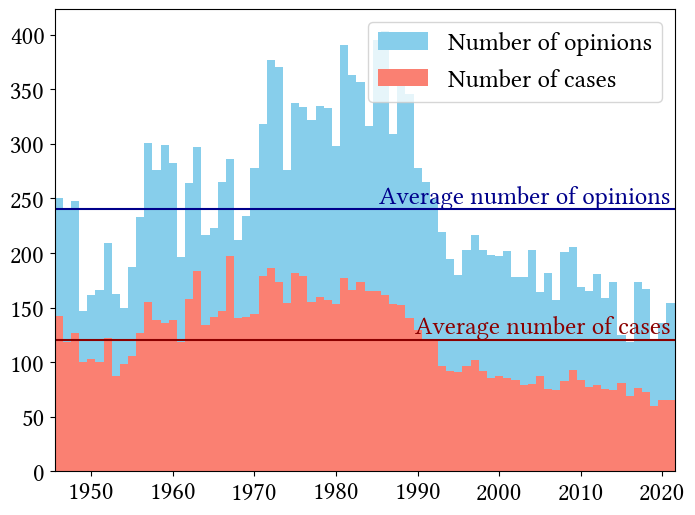

In [6]:
keys = list(opinions_by_year.keys())
n_cases = [len(opinions_by_year[k]) for k in keys]
n_cases_maj = [len(majority_opinions_by_year[k]) for k in keys]
plt.figure(figsize=(8, 6))
plt.bar(keys, n_cases, label="Number of opinions",color='skyblue', width=1)
plt.bar(keys, n_cases_maj, label="Number of cases",color='salmon', width=1)

# plot a line for the average
plt.plot([-1,len(keys)], [np.mean(n_cases),np.mean(n_cases)], color='darkblue')
plt.text(len(keys)-1, np.mean(n_cases), f"Average number of opinions", va='bottom', ha='right', color='darkblue')

plt.plot([-1,len(keys)], [np.mean(n_cases_maj),np.mean(n_cases_maj)], color='darkred')
plt.text(len(keys)-1, np.mean(n_cases_maj), f"Average number of cases", va='bottom', ha='right', color='darkred')

# show only ticks for 1950, 1960, 1970, 1980, 1990, 2000, 2010 and 2020 (every 10 years, but skip the first 4)
plt.xticks(keys[4::10])
plt.xlim(-0.5,len(keys)-0.5)

#240, 121
plt.legend()
plt.savefig('../../../2024-11/figures/number_of_cases_and_opinions.pdf', bbox_inches='tight')
plt.show()

If we look at the last term (2021), we can also look at it as an approval profile:

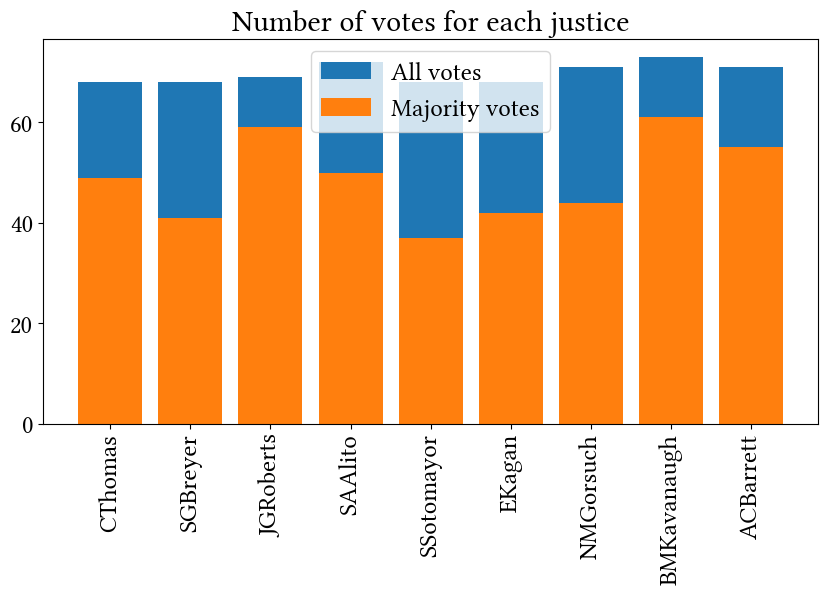

In [7]:
approval_matrix = opinion_to_approval(opinions_by_year["2021"],[108,110,111,112,113,114,115,116,117])
maj_approval_matrix = opinion_to_approval(majority_opinions_by_year["2021"],[108,110,111,112,113,114,115,116,117])
names_2021 = [justice_names[str(i)] for i in [108,110,111,112,113,114,115,116,117]]
plt.figure(figsize=(10, 5))
plt.bar(range(len(names_2021)),approval_matrix.sum(0), label="All votes")
plt.bar(range(len(names_2021)),maj_approval_matrix.sum(0), label="Majority votes")
plt.xticks(range(len(names_2021)), names_2021, rotation=90)
plt.title("Number of votes for each justice")
plt.legend()
plt.show()

The distribution of approval ballots is very interesting, and nothing like what we observe for classical voting dataset. We see a huge spike for size 2, because of dissent and concurrence opinion. Another peak at size 6, because there are 6 Republicans and 3 Democrates in the SC, and another peak around 8-9, for unanimous votes.

In [8]:
tab_length = np.zeros(10)
for year in tqdm(opinions_by_year):
    if len(list_justices[year]) != 9:
        continue 
    names = [justice_names[str(i)] for i in list_justices[year]]
    approval_matrix = opinion_to_approval(opinions_by_year[year], list_justices[year])
    tab_length += [len(approval_matrix[approval_matrix.sum(1) == i]) for i in range(10)]

plt.figure(figsize=(8, 6))
plt.bar(range(2,10), tab_length[2:], color="salmon")
# plt.bar(range(2,10), count_distrib_approval_maj, label="Majority votes")
# plt.title("Distribution of approval sizes")
# plt.xlabel("Number of justices")
plt.ylabel("Number of opinions")
plt.xticks(range(2,10))
# put another y axis on the right with pct point
# plt.ylabel("Percentage of opinions")
# plt.legend()
plt.savefig('../../../2024-11/figures/approval_size_distribution.pdf', bbox_inches='tight')
plt.show()
print(tab_length/sum(tab_length))

  0%|          | 0/76 [00:00<?, ?it/s]


NameError: name 'list_justices' is not defined

Let's focus a bit more on this 2021 term, and compute the optimal axis for our voting rules.

In [9]:
axis_rules = [axis.VoterDeletion, axis.MinimalFlips, axis.BallotCompletion, 
              axis.MinimalSwaps, axis.ForbiddenTriples]

for rule in axis_rules:
    print(rule.name)
    rule_instance = rule(approval_matrix)
    res = rule_instance.bruteforce()
    for el in res:
        axis.print_axis(el[0], names_2021)
    axis_score = rule_instance.get_score(res[0][0])
    print("Score of this axis :", int(axis_score), np.round(axis_score/approval_matrix.shape[0],2))
    print("\n")

Voter Deletion


100%|██████████| 5040/5040 [00:00<00:00, 8276.37it/s]


SSotomayor < SGBreyer < EKagan < JGRoberts < BMKavanaugh < ACBarrett < CThomas < SAAlito < NMGorsuch
SSotomayor < EKagan < SGBreyer < JGRoberts < BMKavanaugh < ACBarrett < CThomas < SAAlito < NMGorsuch
Score of this axis : 57 0.37


Minimal Flips


100%|██████████| 5040/5040 [00:00<00:00, 6247.20it/s]


SSotomayor < SGBreyer < EKagan < JGRoberts < BMKavanaugh < ACBarrett < CThomas < SAAlito < NMGorsuch
SSotomayor < EKagan < SGBreyer < JGRoberts < BMKavanaugh < ACBarrett < CThomas < SAAlito < NMGorsuch
Score of this axis : 60 0.39


Ballot Completion


100%|██████████| 5040/5040 [00:00<00:00, 6828.45it/s]


SGBreyer < EKagan < SSotomayor < NMGorsuch < JGRoberts < BMKavanaugh < ACBarrett < SAAlito < CThomas
EKagan < SGBreyer < SSotomayor < NMGorsuch < JGRoberts < BMKavanaugh < ACBarrett < SAAlito < CThomas
Score of this axis : 116 0.75


Minimal Swaps


100%|██████████| 5040/5040 [00:01<00:00, 3507.01it/s]


SGBreyer < SSotomayor < EKagan < NMGorsuch < JGRoberts < BMKavanaugh < ACBarrett < SAAlito < CThomas
SSotomayor < SGBreyer < EKagan < NMGorsuch < JGRoberts < BMKavanaugh < ACBarrett < SAAlito < CThomas
Score of this axis : 140 0.91


Forbidden Triples


100%|██████████| 5040/5040 [00:01<00:00, 3386.40it/s]

SSotomayor < SGBreyer < EKagan < JGRoberts < BMKavanaugh < ACBarrett < SAAlito < CThomas < NMGorsuch
Score of this axis : 285 1.85




We observe that this dataset is quite consistent with the ideological axis returned, as the cost shows. However, for all rules but FT there are not one but two optimal axis, with some swaps between liberal justices.

All rules (but FT) scores can be lowered if we consider only the majority opinion instead of all opinions. This makes sense: a lot of opinions of size 2 are quite costly for VD, but not at all for FT.

In [10]:
axis_rules = [axis.VoterDeletion, axis.MinimalFlips, axis.BallotCompletion, 
              axis.MinimalSwaps, axis.ForbiddenTriples]

for rule in axis_rules:
    print(rule.name)
    rule_instance = rule(maj_approval_matrix)
    res = rule_instance.bruteforce()
    for el in res:
        axis.print_axis(el[0], names_2021)
    axis_score = rule_instance.get_score(res[0][0])
    print("Score of this axis :", int(axis_score), np.round(axis_score/maj_approval_matrix.shape[0],2))
    print("\n")

Voter Deletion


100%|██████████| 5040/5040 [00:00<00:00, 60195.38it/s]


SSotomayor < EKagan < SGBreyer < JGRoberts < BMKavanaugh < ACBarrett < CThomas < SAAlito < NMGorsuch
SSotomayor < EKagan < SGBreyer < JGRoberts < BMKavanaugh < ACBarrett < SAAlito < CThomas < NMGorsuch
Score of this axis : 14 0.22


Minimal Flips


100%|██████████| 5040/5040 [00:00<00:00, 25161.54it/s]


SSotomayor < EKagan < SGBreyer < JGRoberts < BMKavanaugh < ACBarrett < CThomas < SAAlito < NMGorsuch
SSotomayor < EKagan < SGBreyer < JGRoberts < BMKavanaugh < ACBarrett < SAAlito < CThomas < NMGorsuch
Score of this axis : 17 0.26


Ballot Completion


100%|██████████| 5040/5040 [00:00<00:00, 55882.07it/s]


SSotomayor < EKagan < SGBreyer < JGRoberts < BMKavanaugh < ACBarrett < CThomas < SAAlito < NMGorsuch
Score of this axis : 24 0.37


Minimal Swaps


100%|██████████| 5040/5040 [00:00<00:00, 22460.37it/s]


SSotomayor < SGBreyer < EKagan < JGRoberts < BMKavanaugh < ACBarrett < SAAlito < CThomas < NMGorsuch
Score of this axis : 38 0.58


Forbidden Triples


100%|██████████| 5040/5040 [00:00<00:00, 11228.39it/s]

SSotomayor < SGBreyer < EKagan < JGRoberts < BMKavanaugh < ACBarrett < SAAlito < CThomas < NMGorsuch
Score of this axis : 166 2.55




To conclude on the 2021 term, the [Martin-Quinn metric](https://www.axios.com/2022/10/20/supreme-court-justice-ideology-2022) gives the following order:

SSotomayor < SGBreyer < EKagan < JGRoberts < BMKavanaugh< NMGorsuch < ACBarrett < SAAlito < CThomas 

which is not very far from our axis, even tho none of the rules return this exact axis. To have a better idea, we can compute the Kandall-Tau distance between our resulting axis and the "correct" one.

In [11]:
axis_rules = [axis.VoterDeletion, axis.MinimalFlips, axis.BallotCompletion, 
              axis.MinimalSwaps, axis.ForbiddenTriples]

actual_axis = [4, 1, 5,2,7,6,8,3,0]

for rule in axis_rules:
    print(rule.name)
    rule_instance = rule(approval_matrix)
    res = rule_instance.bruteforce()
    min_dist = 1000
    for el in res:
        min_dist = min(min_dist,axis.kandallTau(el[0],actual_axis))

    actual_score = rule_instance.get_score(actual_axis)
    best_score = rule_instance.get_score(res[0][0])
    print("Kandall Tau distance :", min_dist)
    print("(Score_correct-score_optimal)/score_optimal :",actual_score/best_score-1)
    print("")

Voter Deletion


100%|██████████| 5040/5040 [00:00<00:00, 8434.22it/s] 


Kandall Tau distance : 4
(Score_correct-score_optimal)/score_optimal : 0.21052631578947367

Minimal Flips


100%|██████████| 5040/5040 [00:00<00:00, 6600.97it/s]


Kandall Tau distance : 4
(Score_correct-score_optimal)/score_optimal : 0.2333333333333334

Ballot Completion


100%|██████████| 5040/5040 [00:00<00:00, 7014.43it/s]


Kandall Tau distance : 4
(Score_correct-score_optimal)/score_optimal : 0.02586206896551735

Minimal Swaps


100%|██████████| 5040/5040 [00:01<00:00, 3665.16it/s]


Kandall Tau distance : 2
(Score_correct-score_optimal)/score_optimal : 0.014285714285714235

Forbidden Triples


100%|██████████| 5040/5040 [00:01<00:00, 3501.80it/s]

Kandall Tau distance : 3
(Score_correct-score_optimal)/score_optimal : 0.0736842105263158



Too have a more accurate axis, we could also use the terms of 2020 together with the 2021, as the justices were the same in both. It can be useful because this gives more data to base our analysis on. However, it does not take into account that justices can change from one term to another.

Let's start to look at this data on a larger scale and consider all terms. During some terms, there was a change of justice, and the total number of justice voting during the term is greater than 9. I propose to exclude those terms for this analysis, so we can focus on all terms with 9 justices.

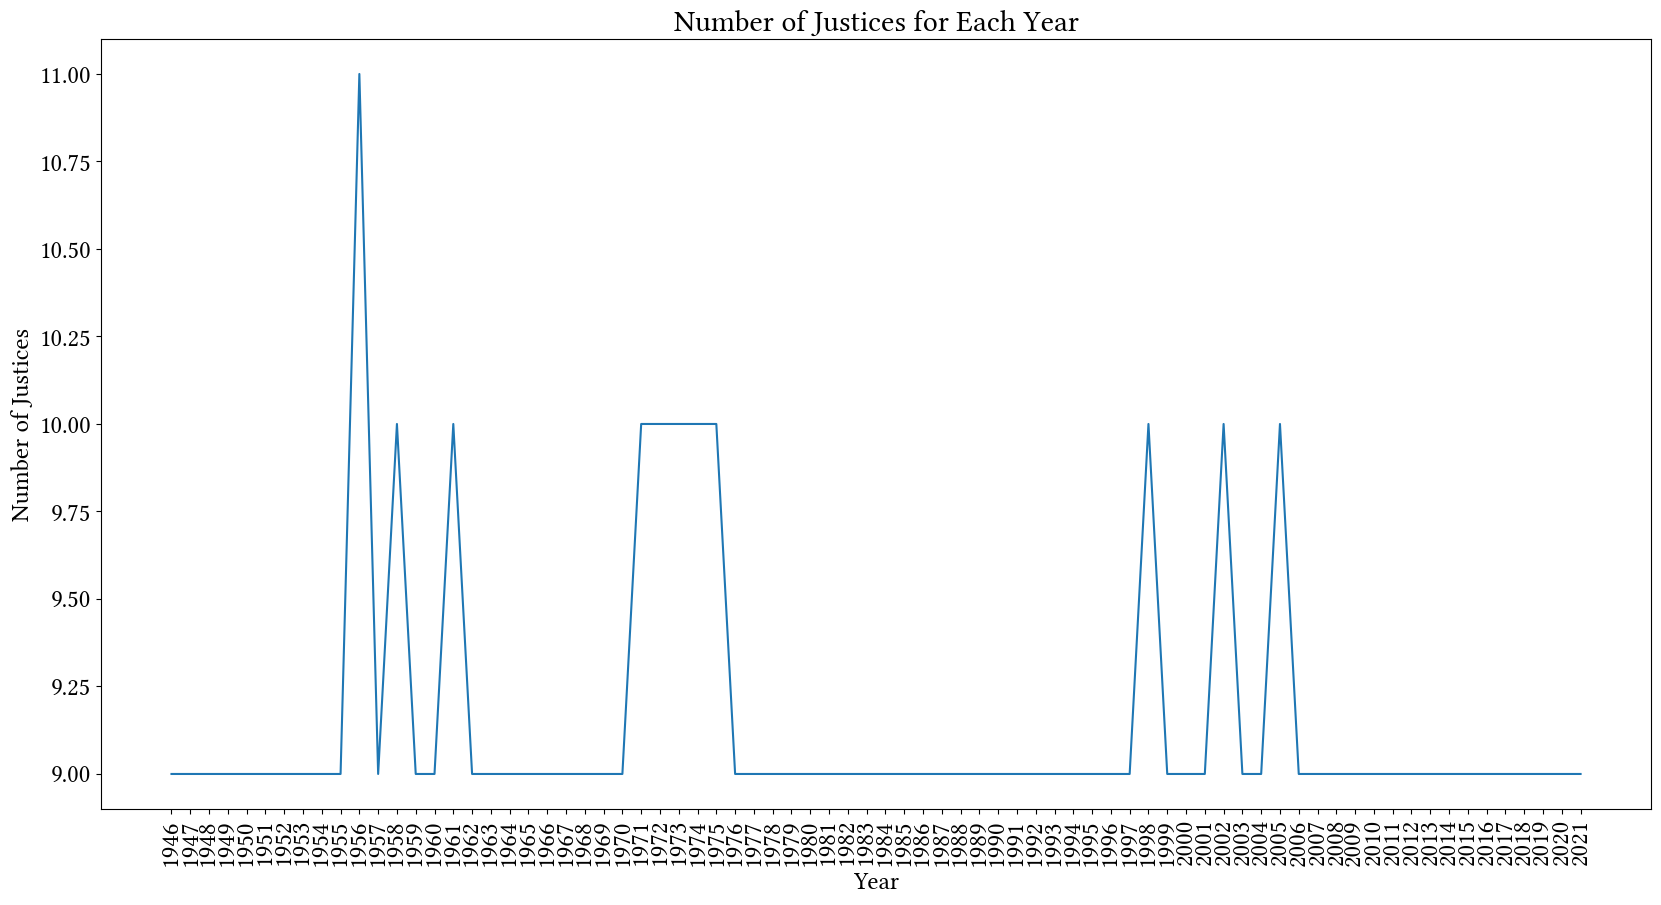

In [12]:
# count the number of different justice for each year:

number_justices = []
list_justices ={}
for k in keys:
    l = []
    for op in opinions_by_year[k]:
        for j in op:
            if j not in l:
                l.append(j)
    number_justices.append(len(l))
    list_justices[k] = l

# plot the number of justices for each year:
plt.figure(figsize=(20,10))
plt.plot(keys, number_justices)
plt.xticks(keys, keys, rotation='vertical')
plt.xlabel('Year')
plt.ylabel('Number of Justices')
plt.title('Number of Justices for Each Year')
plt.show()
    


As explained before, we want to use as benchmark the Martin-Quinn measure, which seems to be the most used measure when it comes to put the justices on a left-right / liberal-conservative axis. In the following code, we load this data and compute the Martin-Quinn axis for each term.

In [13]:
df_martin_quinn = pd.read_csv('data/martin_quinn.csv')
dict_year_values = {}
for i_row, row in df_martin_quinn.iterrows():
    if row['term'] not in dict_year_values.keys():
        dict_year_values[row['term']] = []
    dict_year_values[row['term']].append((row['post_mn'], row["justice"]))

dict_year_order = {}
for year in dict_year_values.keys():
    dict_year_order[year] = [x[1] for x in sorted(dict_year_values[year], key=lambda x: x[0])]

In the following code, we run the axis rules for each year on the complete data (all opinions) and save all the optimal rules. We also run the rules on the Martin-Quinn ordering.

In [20]:
axis_rules = [axis.VoterDeletion, axis.MinimalFlips, axis.BallotCompletion,  axis.MinimalSwaps, axis.ForbiddenTriples]

count_el = 0
tab_results = []
tab_actual = []
#
prev_axis = [None]*len(axis_rules)
#
for year in tqdm(opinions_by_year):
    if len(list_justices[year]) != 9:
        continue 
    names = [justice_names[str(i)] for i in list_justices[year]]
    approval_matrix = opinion_to_approval(opinions_by_year[year], list_justices[year])
    count_el += 1
    success = np.zeros((len(axis_rules)))
    actual = dict_year_order[int(year)]
    for k, rule in enumerate(axis_rules):
        rule_instance = rule(approval_matrix)
        #
        suborder=None
        if prev_axis[k] is not None:
            # print(prev_axis[k], names)
            suborder = []
            for i in range(len(prev_axis[k])):
                if prev_axis[k][i] in names:
                    suborder.append(names.index(prev_axis[k][i]))
        res = rule_instance.bruteforce(suborder=suborder, coeff=0.05)
        axis_score = rule_instance.get_score(res[0][0])
        for el in res:
            best_axis = [list_justices[year][x] for x in el[0]]
            tab_results_i = [year, rule.name, len(res), axis_score] + best_axis
            tab_results.append(tab_results_i)
        #
        prev_axis[k] = [names[x] for x in res[0][0]]
        #
        score_actual = rule_instance.get_score([list_justices[year].index(x) for x in actual])
        tab_actual_i = [year, rule.name, score_actual] + actual
        tab_actual.append(tab_actual_i)


100%|██████████| 76/76 [33:22<00:00, 26.35s/it]


And we save the results somewhere

In [21]:
df = pd.DataFrame(tab_results, columns=["year", "rule", "n_optimal", "score"] + ["axis_%i"%i for i in range(1,10)])
df.to_csv("data/scotus_results_alpha5pct.csv", index=False)

df2 = pd.DataFrame(tab_actual, columns=["year", "rule", "score"] + ["axis_%i"%i for i in range(1,10)])
df2.to_csv("data/scotus_martin_quinn.csv", index=False)

We can then load the data:

In [22]:
tab_results = pd.read_csv('data/scotus_results_alpha5pct.csv').to_numpy()
tab_actual = pd.read_csv('data/scotus_martin_quinn.csv').to_numpy()

Let's now compare our 2 dataset. We can go very direct and compute howw many times the returned axis is equal to the martin quinn axis.

In [23]:
dict_year = {}
for elem in tab_results:
    yr = elem[0]
    if yr not in dict_year:
        dict_year[yr] = {}
    rule = elem[1]
    if elem[1] not in dict_year[yr]:
        dict_year[yr][rule] = {"optimal":[]}
    dict_year[yr][rule]["optimal"].append(elem[4:])
    dict_year[yr][rule]["best_score"] = elem[3]

for elem in tab_actual:
    yr = elem[0]
    rule = elem[1]
    dict_year[yr]["martinQuinn"] = elem[3:]
    dict_year[yr][rule]["mq_score"] =elem[2]



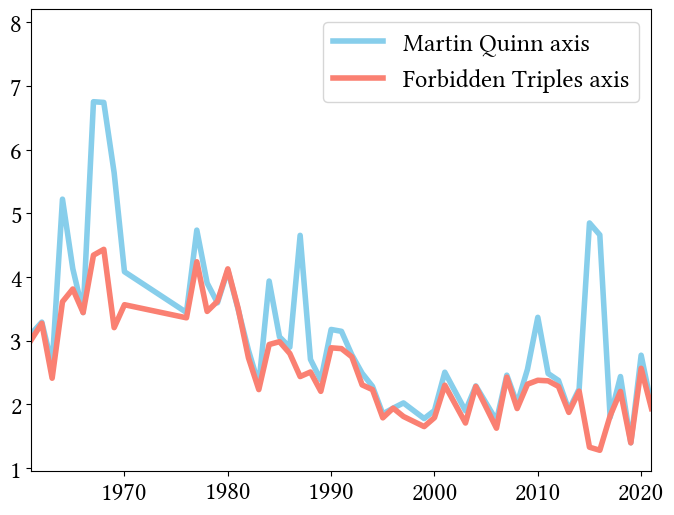

In [24]:
vd_score_mq = np.zeros(len(dict_year))
vd_score_vd = np.zeros(len(dict_year))

for i, year in enumerate(dict_year):
    m = opinion_to_approval(opinions_by_year[str(year)], list_justices[str(year)])
    n_voters = m.shape[0]
    vd_score_mq[i] = dict_year[year]["Forbidden Triples"]["mq_score"]/n_voters
    vd_score_vd[i] = dict_year[year]["Forbidden Triples"]["best_score"]/n_voters

plt.figure(figsize=(8, 6))
plt.plot(list(dict_year.keys()), vd_score_mq, label="Martin Quinn axis",color="skyblue", linewidth=4)
plt.plot(list(dict_year.keys()), vd_score_vd, label="Forbidden Triples axis", color="salmon", linewidth=4)
# plt.xlabel("Year")
# plt.ylabel("Score")
plt.xlim(1961,2021)
plt.legend()
plt.savefig('../../../2024-11/figures/forbidden_triples_score.pdf', bbox_inches='tight')
plt.show()

In [22]:
rules = ["Voter Deletion", "Minimal Flips", "Ballot Completion", "Minimal Swaps", "Forbidden Triples"]

for rule in rules:
    total = 0
    count = 0
    for i, year in enumerate(dict_year):
        m = opinion_to_approval(opinions_by_year[str(year)], list_justices[str(year)])
        n_voters = m.shape[0]
        total += dict_year[year][rule]["best_score"]/n_voters
        count += 1

    print(rule, total/count)


Voter Deletion 0.4465277407277527
Minimal Flips 0.5221121694182511
Ballot Completion 0.8873787114547683
Minimal Swaps 1.0884002490038698
Forbidden Triples 2.7213213758727863


Voter Deletion 0.44652774072775275
Minimal Flips 0.5221121694182514
Ballot Completion 0.8873787114547681
Minimal Swaps 1.0884002490038698
Forbidden Triples 2.721321375872786


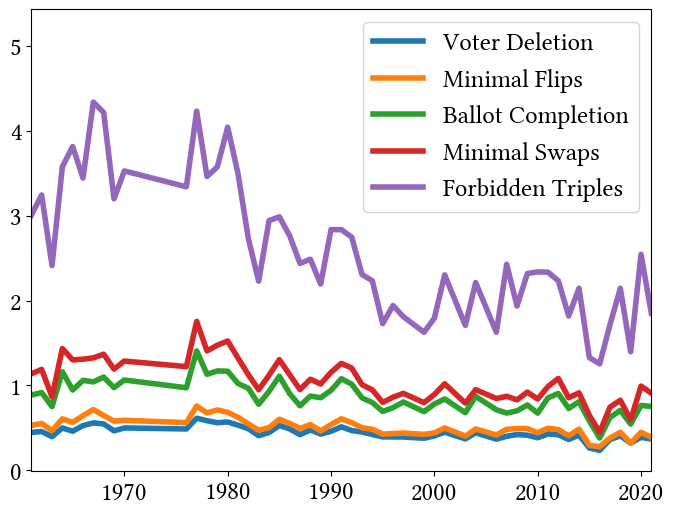

In [23]:
score_best = np.zeros((len(dict_year), 5))
rules = ["Voter Deletion", "Minimal Flips", "Ballot Completion", "Minimal Swaps", "Forbidden Triples"]

for i, year in enumerate(dict_year):
    m = opinion_to_approval(opinions_by_year[str(year)], list_justices[str(year)])
    n_voters = m.shape[0]
    for j in range(5):
        rule = rules[j]
        score_best[i,j] = dict_year[year][rule]["best_score"]/n_voters



plt.figure(figsize=(8, 6))
# colormap skyblue, salmon, ...

# colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'violet'] 

# print average of each rule

for j in range(5):
    plt.plot(list(dict_year.keys()), score_best[:,j], label=rules[j], linewidth=4)#, color=colors[j])
    print(rules[j], np.mean(score_best[:,j]))
# plt.xlabel("Year")
# plt.ylabel("Score")
plt.xlim(1961,2021)
plt.legend()
plt.savefig('../../../2024-11/figures/all_rulesscore.pdf', bbox_inches='tight')
plt.show()

[0.552 0.528 0.564 0.52  0.532 0.544 0.532 0.548 0.488]
[0.552 0.528 0.564 0.52  0.544 0.532 0.532 0.548 0.488]
[0.528 0.564 0.552 0.52  0.544 0.532 0.532 0.548 0.488]
[0.528 0.552 0.564 0.52  0.544 0.532 0.532 0.548 0.488]
[0.552 0.564 0.528 0.52  0.544 0.532 0.532 0.488 0.548]
[0.47698745 0.46443515 0.51046025 0.49790795 0.45606695 0.46443515
 0.48117155 0.45188285 0.40167364]
[0.47698745 0.49790795 0.51046025 0.46443515 0.46443515 0.45606695
 0.48117155 0.45188285 0.40167364]
[0.46443515 0.51046025 0.49790795 0.47698745 0.45606695 0.46443515
 0.48117155 0.45188285 0.40167364]
[0.46443515 0.47698745 0.51046025 0.49790795 0.45606695 0.46443515
 0.48117155 0.45188285 0.40167364]
[0.47698745 0.46443515 0.51046025 0.49790795 0.46443515 0.45606695
 0.48117155 0.45188285 0.40167364]
[0.44758065 0.47177419 0.47580645 0.48790323 0.46774194 0.43951613
 0.44354839 0.45967742 0.4233871 ]
[0.44758065 0.47177419 0.47580645 0.48790323 0.46774194 0.43951613
 0.44354839 0.45967742 0.4233871 ]
[0.447

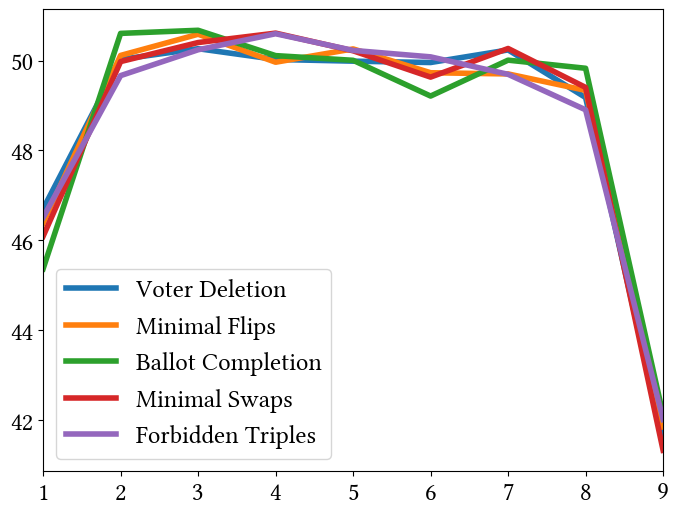

[0.         0.03076923 0.         0.04615385 0.01538462]


In [ ]:
avg_popularity = np.zeros((5,9))
rules = ["Voter Deletion", "Minimal Flips", "Ballot Completion", "Minimal Swaps", "Forbidden Triples"]

def is_singlepeaked(tab):
    increasing = True 
    n = len(tab)
    for i in range(len(tab)-1):
        if tab[i] > tab[i+1]:
            increasing = False
        elif tab[i] < tab[i+1] and not increasing:
            return False
    return True

single_peaked = np.zeros(5)
for i, year in enumerate(dict_year):
    m = opinion_to_approval(opinions_by_year[str(year)], list_justices[str(year)])
    n_voters = m.shape[0]
    scores_justices = m.sum(0)
    for j in range(5):
        rule = rules[j]
        axis_res = dict_year[year][rule]["optimal"][0]
        pop_tab = np.zeros(9)
        for k in range(9):
            ind_justice = list_justices[str(year)].index(axis_res[k])
            avg_popularity[j,k] += scores_justices[ind_justice]/n_voters
            pop_tab[k] = scores_justices[ind_justice]/n_voters

        print(pop_tab)
        if is_singlepeaked(pop_tab):
            single_peaked[j] += 1


avg_popularity *= 100/len(dict_year)

plt.figure(figsize=(8, 6))
# colormap skyblue, salmon, ...

# colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'violet']

# print average of each rule

for j in range(5):
    plt.plot(range(1,10), avg_popularity[j,:], label=rules[j], linewidth=4)#, color=colors[j])
# plt.xlabel("Year")
# plt.ylabel("Score")
plt.xlim(1,9)
plt.legend()
plt.savefig('../../../2024-11/figures/all_rules_popularity.pdf', bbox_inches='tight')
plt.show()

print(single_peaked/len(dict_year))



In [33]:
overall_score = np.zeros(5)
rules_name = ["Voter Deletion", "Minimal Flips", "Ballot Completion", "Minimal Swaps", "Forbidden Triples"]
for yr in dict_year:
    for rule in rules_name:
        if dict_year[yr][rule]["best_score"] == dict_year[yr][rule]["mq_score"]:
            overall_score[rules_name.index(rule)] += 1

results = 100*overall_score/len(dict_year)

for i in range(5):
    print(rules_name[i], ":", np.round(results[i], 2), "%")

Voter Deletion : 4.62 %
Minimal Flips : 4.62 %
Ballot Completion : 7.69 %
Minimal Swaps : 7.69 %
Forbidden Triples : 6.15 %


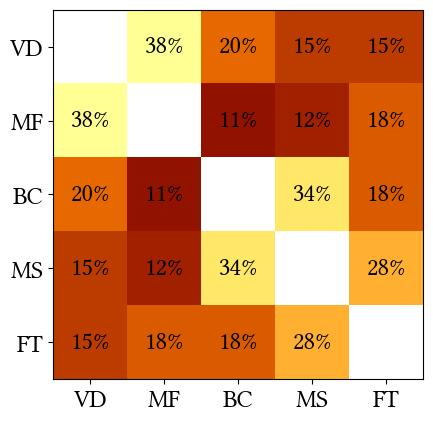

In [41]:
overall_score = np.zeros((5,5))
rules_name = ["Voter Deletion", "Minimal Flips", "Ballot Completion", "Minimal Swaps", "Forbidden Triples"]
rulesshort = ["VD", "MF", "BC", "MS", "FT"]
for yr in dict_year:
    for i in range(5):
        for j in range(i, 5):
            axis1 = str(list(dict_year[yr][rules_name[i]]["optimal"][0]))
            axis2 = str(list(dict_year[yr][rules_name[j]]["optimal"][0]))
            axis2rev = str(list(dict_year[yr][rules_name[j]]["optimal"][0])[::-1])
            if  axis1 == axis2 or axis1 == axis2rev:
                overall_score[i,j] += 1
            

results = 100*overall_score/len(dict_year)
results += results.T
for i in range(5):
    results[i,i] = 50
plt.imshow(results, cmap='afmhot', interpolation='nearest', vmin=-5, vmax=50)

plt.xticks(range(5), rulesshort)
plt.yticks(range(5), rulesshort)

# labels
for i in range(5):
    for j in range(5):
        if i >= j:
            continue
        plt.text(j, i, f"{results[i, j]:.0f}%", ha='center', va='center', color='black')
        plt.text(i, j, f"{results[i, j]:.0f}%", ha='center', va='center', color='black')

plt.savefig('../../../2024-11/figures/matching_btw_rules.pdf', bbox_inches='tight')
plt.show()





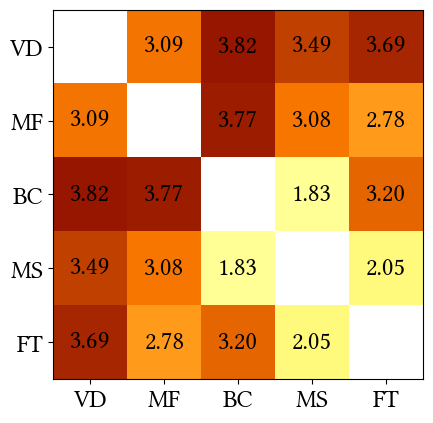

In [48]:
overall_score = np.zeros((5,5))
rules_name = ["Voter Deletion", "Minimal Flips", "Ballot Completion", "Minimal Swaps", "Forbidden Triples"]
rulesshort = ["VD", "MF", "BC", "MS", "FT"]
for yr in dict_year:
    for i in range(5):
        for j in range(i+1, 5):
            axis1 = list(dict_year[yr][rules_name[i]]["optimal"][0])
            axis2 = list(dict_year[yr][rules_name[j]]["optimal"][0])
            axis2rev = list(dict_year[yr][rules_name[j]]["optimal"][0])[::-1]
            distkt = min(axis.kandallTau(axis1, axis2), axis.kandallTau(axis1, axis2rev))
            overall_score[i,j] += distkt

            

results = overall_score/len(dict_year)
for i in range(5):
    results[i,i] = 0

results += results.T



# reverse colormap
plt.imshow(results, cmap='afmhot_r', interpolation='nearest', vmin=1, vmax=5)

plt.xticks(range(5), rulesshort)
plt.yticks(range(5), rulesshort)

# labels
for i in range(5):
    for j in range(5):
        if i >= j:
            continue
        plt.text(j, i, f"{results[i, j]:.2f}", ha='center', va='center', color='black')
        plt.text(i, j, f"{results[i, j]:.2f}", ha='center', va='center', color='black')


plt.savefig('../../../2024-11/figures/kendall_tau_btw_rules.pdf', bbox_inches='tight')
plt.show()


Well, FT achieve the best score with $7\%$, which is not particularly great. Let's see if the kandall Tau distance can be more helpful

In [32]:
overall_score = np.zeros(5)

for yr in dict_year:
    axis_mq = dict_year[yr]["martinQuinn"]
    for rule in rules_name:
        min_dist = 1000
        for best_axis in dict_year[yr][rule]["optimal"]:
            min_dist = min(min_dist, axis.kandallTau(axis_mq, best_axis))
            min_dist = min(min_dist, axis.kandallTau(axis_mq[::-1], best_axis))
        overall_score[rules_name.index(rule)] += min_dist



results = overall_score/len(dict_year)

for i in range(5):
    print(rules_name[i], ":", np.round(results[i], 2))

Voter Deletion : 10.92
Minimal Flips : 5.2
Ballot Completion : 3.68
Minimal Swaps : 3.69
Forbidden Triples : 3.42


In [34]:
overall_score = np.zeros(5)

for yr in dict_year:
    axis_mq = dict_year[yr]["martinQuinn"]
    for rule in rules_name:
        ok = True
        for best_axis in dict_year[yr][rule]["optimal"]:
            if best_axis[4] != axis_mq[4]:
                ok = False
        if ok == True:
            overall_score[rules_name.index(rule)] += 1



results = overall_score/len(dict_year)

print(len(dict_year))

for i in range(5):
    print(rules_name[i], ":", np.round(results[i], 2))

65
Voter Deletion : 0.12
Minimal Flips : 0.55
Ballot Completion : 0.63
Minimal Swaps : 0.66
Forbidden Triples : 0.68


It seems there are no big differences between the rules, however FT still achieve the best KT distance, and the KT distances are very small for all rules: between 3 and 5 inversions in average. It is very interesting to see that the more information we use, the better the rule.

We can also compare the relative score of the optimal axis with the score of the martin quinn axis:

In [ ]:
overall_score = np.zeros(5)
for yr in dict_year:
    for rule in rules_name:
        relative_diff = (dict_year[yr][rule]["mq_score"]-dict_year[yr][rule]["best_score"])/dict_year[yr][rule]["best_score"]
        overall_score[rules_name.index(rule)] += relative_diff

results = 100*overall_score/len(dict_year)

for i in range(5):
    print(rules_name[i], ":", np.round(results[i], 2), "%")

Voter Deletion : 21.65 %
Minimal Flips : 22.44 %
Ballot Completion : 16.34 %
Minimal Swaps : 19.09 %
Forbidden Triples : 26.92 %


Perhaps surprisingly, the FT is the one for which the relative difference is the highest. To makes sense of this, notice that the cost for FT can increase exponentially when adding inconsistencies: one disapproved candidate in the center of 6 approved candidates can cost 9, while it cost 1 to VD, MF, BC, and 3 to MS.

Finally, we could plot the trajectories of the various justices, at least those of the last 3 decades (Since justice Thomas started).

In [28]:
starting_year = 2010
n_years = 2022 - starting_year
rules_name = ["Voter Deletion", "Minimal Flips", "Ballot Completion", "Minimal Swaps", "Forbidden Triples"]
rulesshort = ["VD", "MF", "BC", "MS", "FT"]

dict_justices_plot = {}
for year in range(starting_year,2022):
    if year not in dict_year:
        continue
    infos = dict_year[(year)]
    for rule in rules_name:
        best_axis = dict_year[year][rule]["optimal"][0]
        if list(best_axis).index(108) < 5:
            best_axis = best_axis[::-1]
        for i, j in enumerate(best_axis):
            if j not in dict_justices_plot:
                dict_justices_plot[j] = {}
            if rule not in dict_justices_plot[j]:
                dict_justices_plot[j][rule] = [-1]*(n_years)
            dict_justices_plot[j][rule][year-starting_year] = i
    for i, j in enumerate(infos["martinQuinn"]):
        if "martinQuinn" not in dict_justices_plot[j]:
            dict_justices_plot[j]["martinQuinn"] = [-1]*(n_years)
        dict_justices_plot[j]["martinQuinn"][year-starting_year] = i

In [ ]:
dict_justices_plot.keys()
print(len(dict_justices_plot.keys()))

order = [7,6,8,-1,-3,-2,5,4,0,1,2,3]

dict_keys([114, 113, 109, 110, 108, 105, 111, 112, 106, 115, 116, 117])

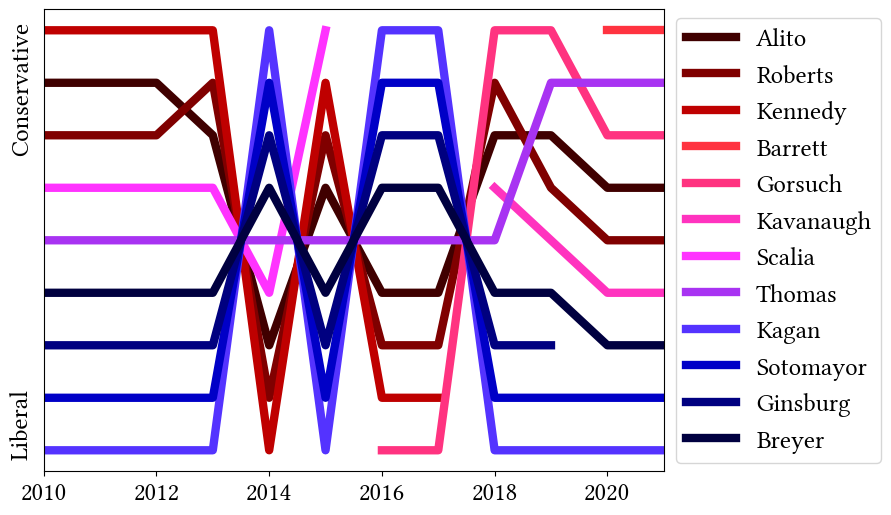

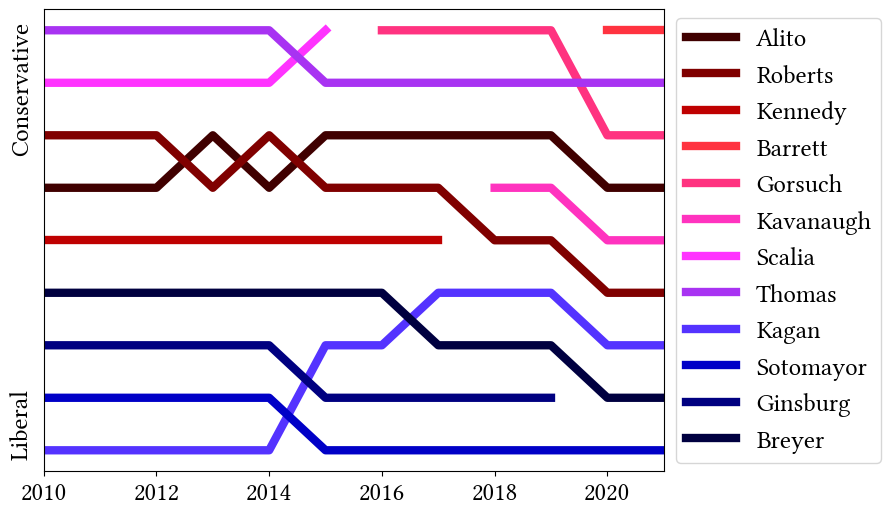

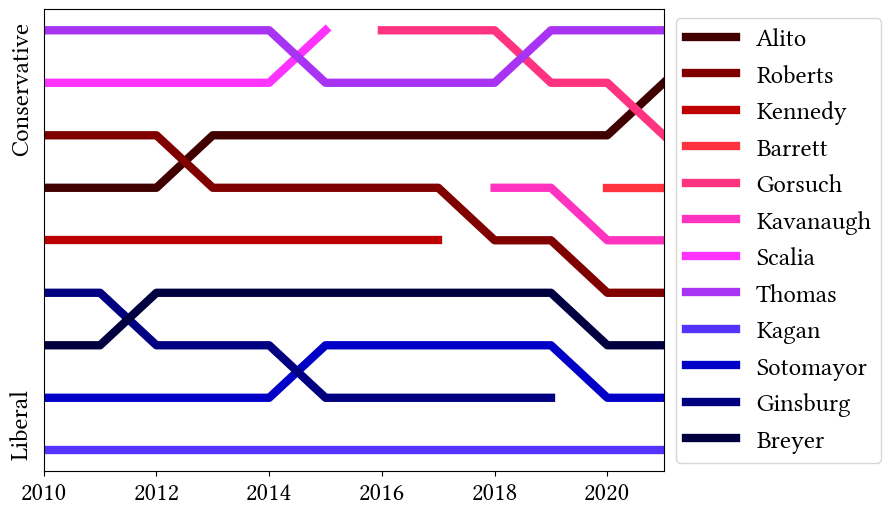

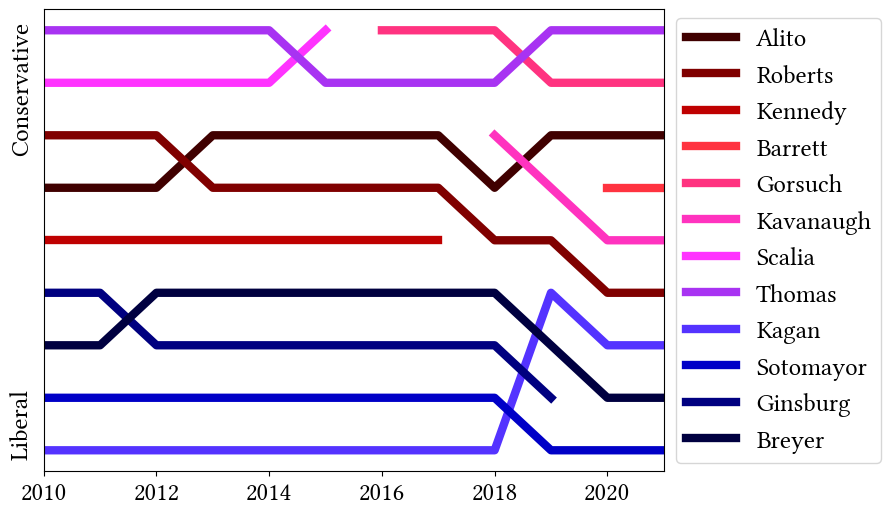

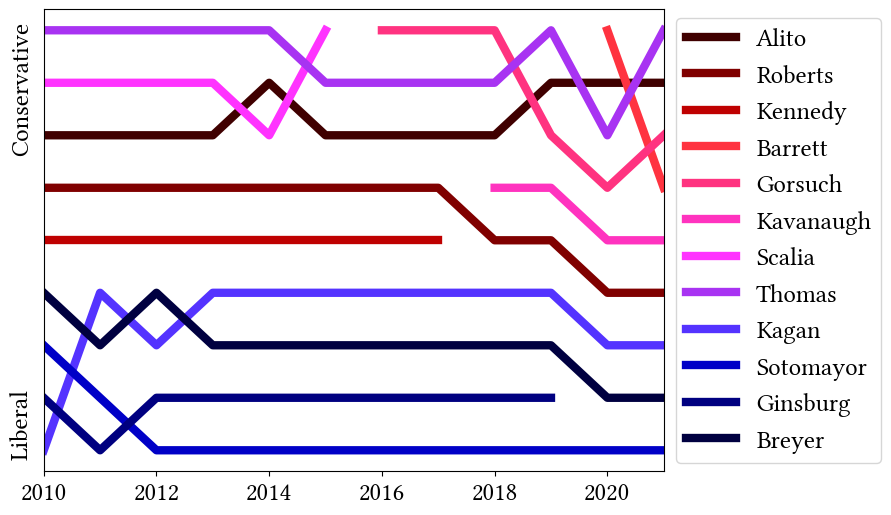

In [30]:
colors = [[0,0,0.25,1],[0,0,0.5,1],[0,0,0.78,1], 
          [0.33,0.2,1,1],[0.66,0.2,0.95,1],[1,0.2,1,1],
          [1,0.2,0.75,1],[1,0.2,0.5,1],[1,0.2,0.25,1],
          [0.75,0,0,1],[0.5,0,0,1],[0.25,0,0,1]][::-1]


for rule in rules_name:
    plt.figure(figsize=(8, 6))
    # set colormap Red Purple Blue
    # colors = pl.cm.brg(np.linspace(0,0.25,len(dict_justices_plot.keys())))
    # print(colors)
    for k in range(len(dict_justices_plot)):
        justice = list(dict_justices_plot.keys())[order[k]]
        t = dict_justices_plot[justice]
        # name = starting from the first capital letter
        name = justice_names[str(justice)]
        for i in range(len(name)):
            if name[len(name)-1-i].isupper():
                name = name[len(name)-1-i:]
                break

        plt.plot([starting_year+i for i in range(n_years) if t[rule][i] >=0], 
        [t[rule][i] for i in range(n_years) if t[rule][i] >=0],
        '-',
        linewidth=6,
        color=colors[k],
        label=name)

    plt.xlim(2010,2021)
    plt.yticks([1,8],["Liberal", "Conservative"], rotation=90)
    # hide y ticks tick but not label
    plt.gca().tick_params(axis='y', which='both', left=False, right=False)
    # put the legend next to the figure (on the right)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.xlabel("Year")
    # plt.title("Evolution of the position of the justices on the "+rule+" axis")
    plt.savefig('../../../2024-11/figures/evolution_'+rule+'.pdf', bbox_inches='tight')
    plt.show()


We see a lot of instability from one year to another. To get more stability, we could use the datasets of several following years. The only thing that is stable is that the Libearl are always on one side and the Conservatives on the other.

We can also plot the evolution for the MartinQuinn measure. Of course it is more stable as it is based not only on the current term but also the previous term of the justice. Moreover, this metric follows a Markov dynamic and its value at t+1 depends on its value at t.

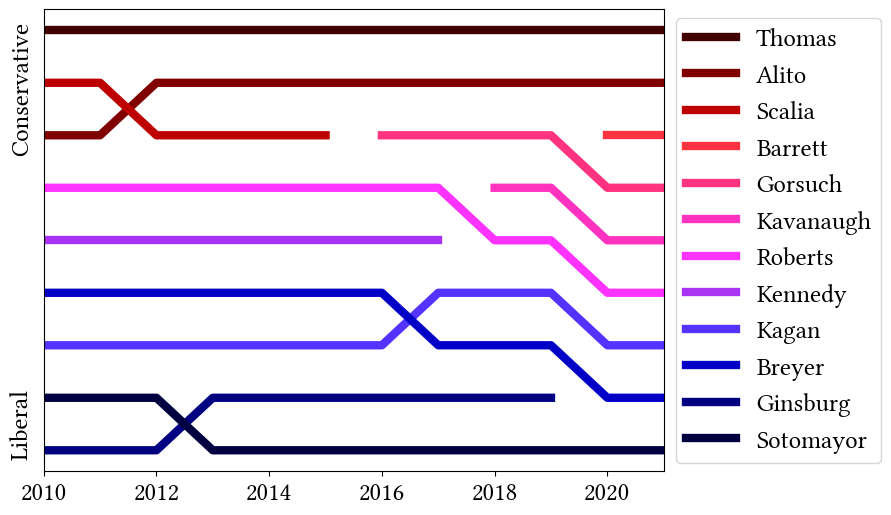

In [73]:
plt.figure(figsize=(8, 6))
# colors = pl.cm.jet(np.linspace(0,1,len(dict_justices_plot.keys())))
rule ="martinQuinn"
for k in range(len(dict_justices_plot)):
    justice = list(dict_justices_plot.keys())[order[k]]
    t = dict_justices_plot[justice]
    name = justice_names[str(justice)]
    for i in range(len(name)):
        if name[len(name)-1-i].isupper():
            name = name[len(name)-1-i:]
            break
    plt.plot([starting_year+i for i in range(n_years) if t[rule][i] >=0], 
    [t[rule][i] for i in range(n_years) if t[rule][i] >=0],
    '-',
    linewidth=6,
    color=colors[k],
    label=name)

plt.xlim(2010,2021)
plt.yticks([1,8],["Liberal", "Conservative"], rotation=90)
# hide y ticks tick but not label
plt.gca().tick_params(axis='y', which='both', left=False, right=False)
# put the legend next to the figure (on the right)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../../../2024-11/figures/evolution_martinQuinn.pdf', bbox_inches='tight')
plt.show()

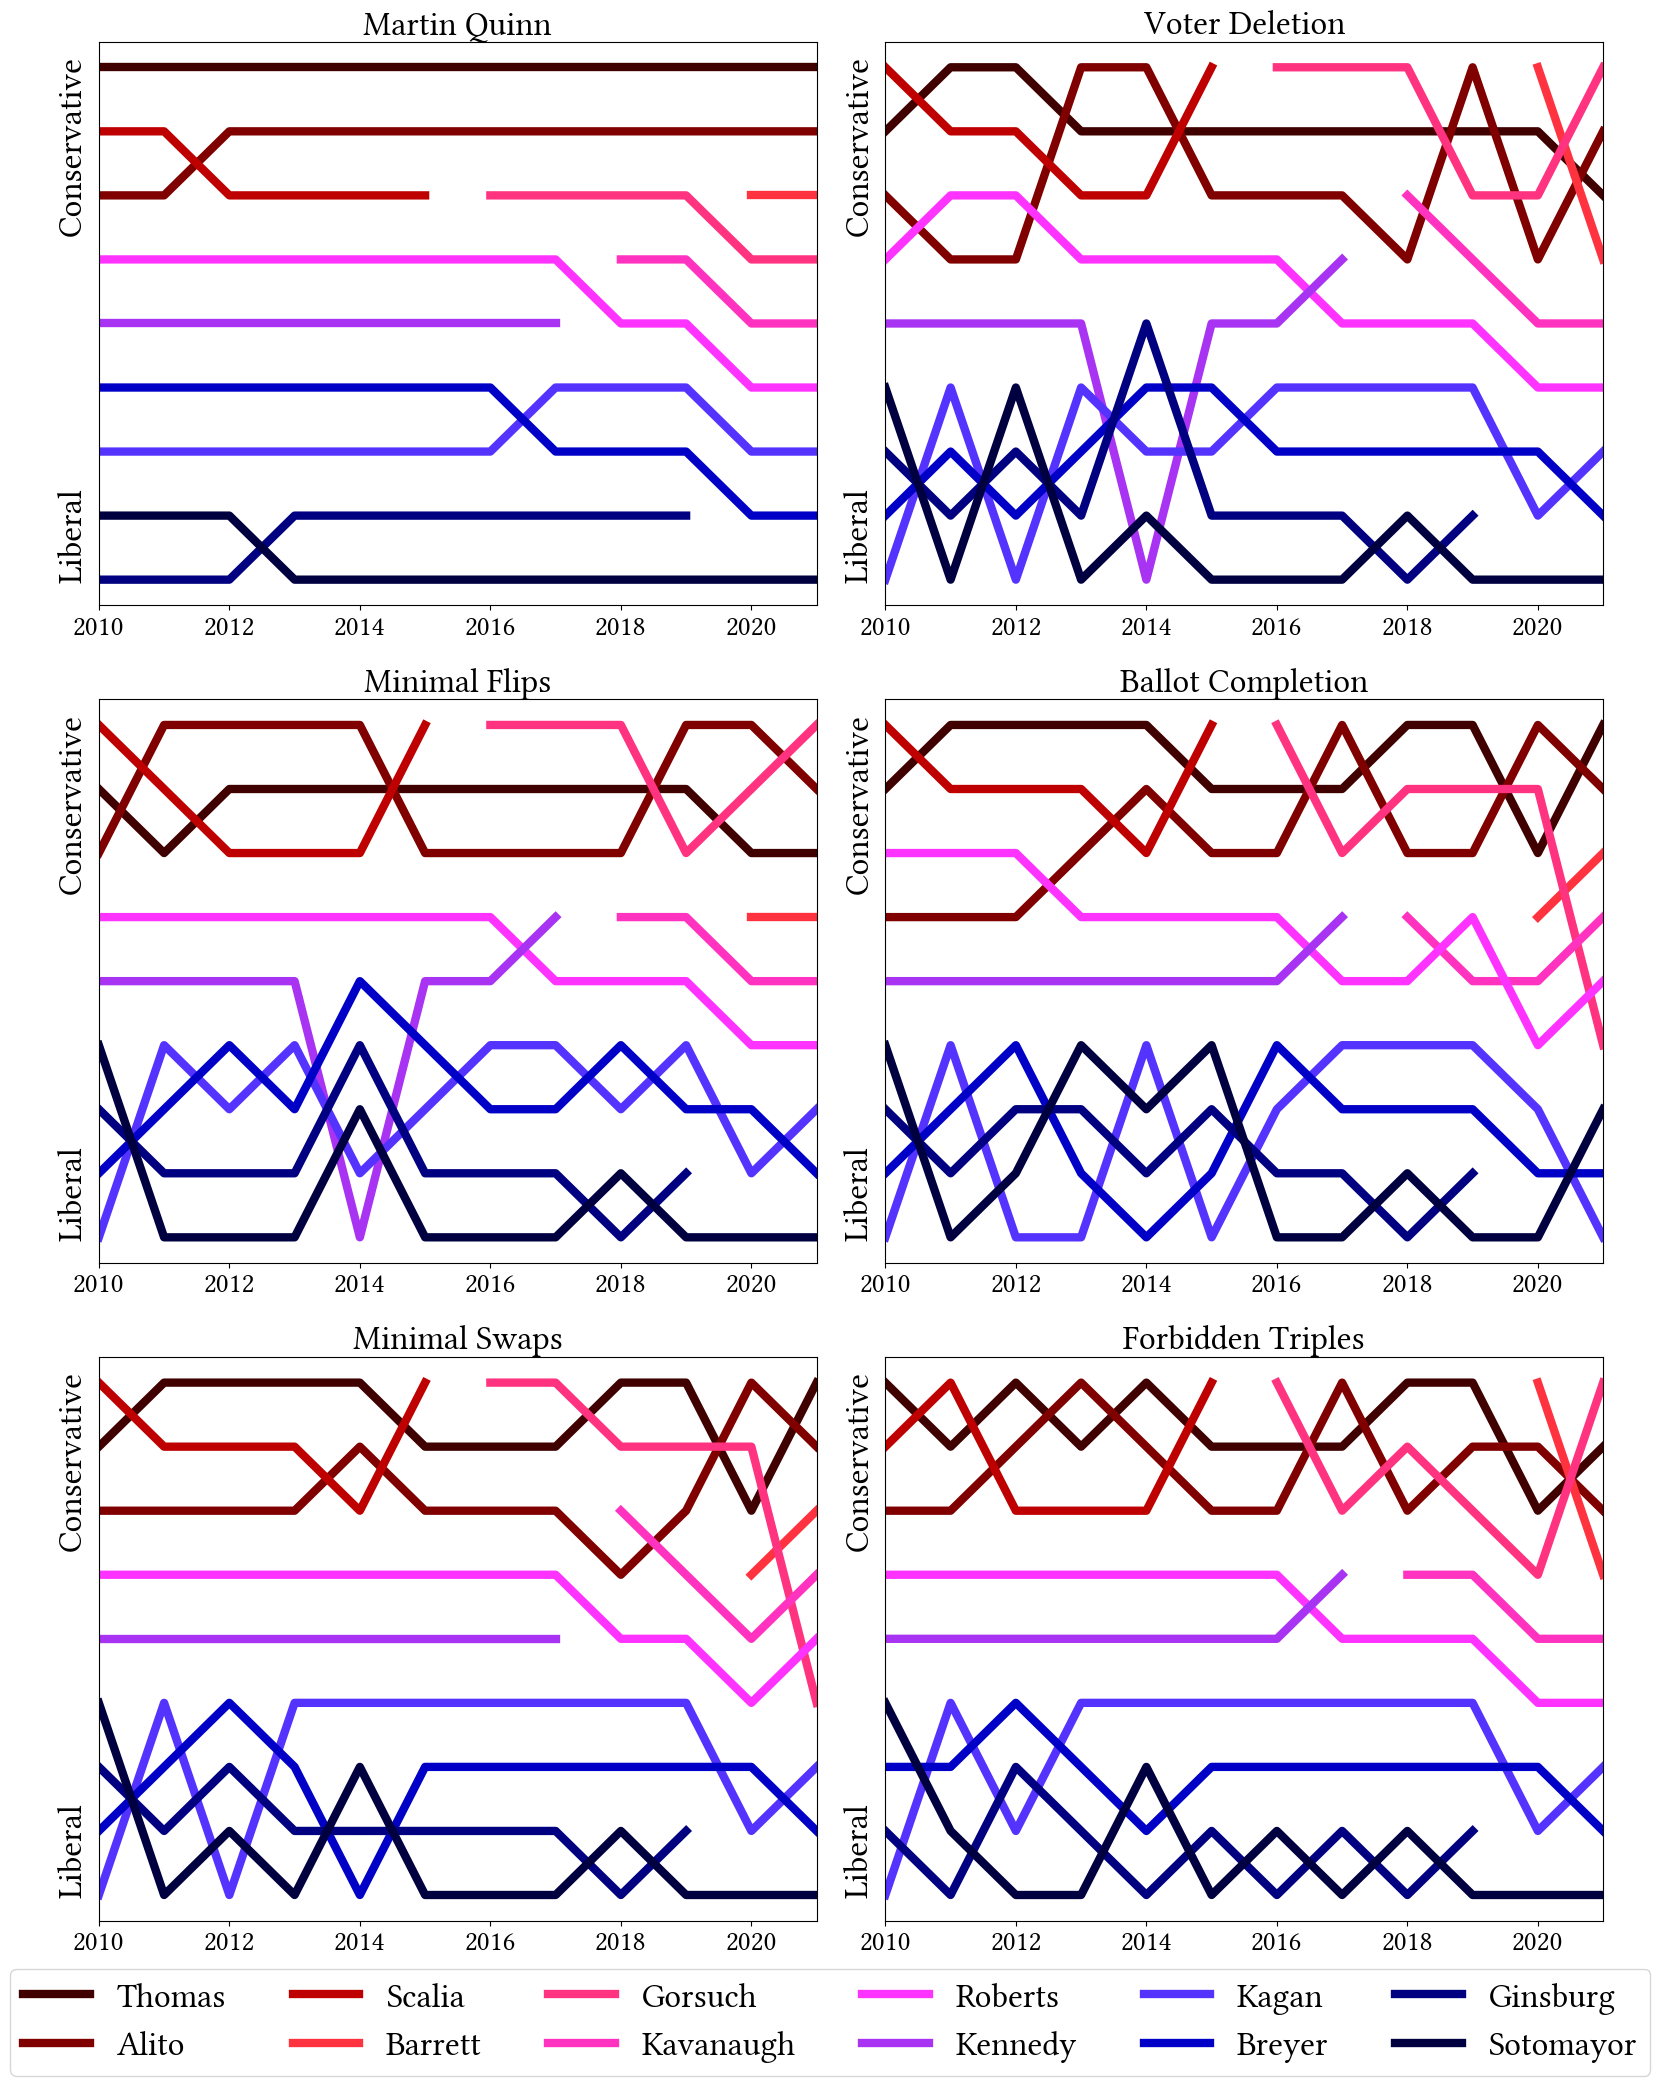

In [89]:
# the 6 in one figure 2 col 3 rows
reorder = lambda l, nc: sum((l[i::nc] for i in range(nc)), [])
fig, axs = plt.subplots(3, 2, figsize=(16, 20))

for j, rule in enumerate(rules_name):
    i = j+1
    ax = axs[i//2, i%2]
    for k in range(len(dict_justices_plot)):
        justice = list(dict_justices_plot.keys())[order[k]]
        t = dict_justices_plot[justice]
        name = justice_names[str(justice)]
        for i in range(len(name)):
            if name[len(name)-1-i].isupper():
                name = name[len(name)-1-i:]
                break
        ax.plot([starting_year+i for i in range(n_years) if t[rule][i] >=0], 
        [t[rule][i] for i in range(n_years) if t[rule][i] >=0],
        '-',
        linewidth=6,
        color=colors[k],
        label=name)

    ax.set_xlim(2010,2021)
    ax.set_xticks([2010,2012,2014,2016,2018,2020])
    ax.set_xticklabels(["2010","2012","2014","2016","2018","2020"], fontsize=20)
    ax.set_yticks([1.25,8], ["Liberal", "Conservative"], rotation=90, fontsize=24)

    # hide y ticks tick but not label
    ax.tick_params(axis='y', which='both', left=False, right=False)
    # put the legend next to the figure (on the right)
    if j == 4:
        # legend below the figure not on the left or right
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels,
             loc='center', bbox_to_anchor=(0.5, -0.02), ncol=6, fontsize=24)
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_xlabel("Year")
    ax.set_title(rule, fontsize=24)


# add MQ in #1
ax = axs[0, 0]
for k in range(len(dict_justices_plot)):
    justice = list(dict_justices_plot.keys())[order[k]]
    t = dict_justices_plot[justice]
    name = justice_names[str(justice)]
    for i in range(len(name)):
        if name[len(name)-1-i].isupper():
            name = name[len(name)-1-i:]
            break
    ax.plot([starting_year+i for i in range(n_years) if t["martinQuinn"][i] >=0], 
    [t["martinQuinn"][i] for i in range(n_years) if t["martinQuinn"][i] >=0],
    '-',
    linewidth=6,
    color=colors[k],
    label=name)

ax.set_xlim(2010,2021)
ax.set_xticks([2010,2012,2014,2016,2018,2020])
ax.set_xticklabels(["2010","2012","2014","2016","2018","2020"], fontsize=20)
ax.set_yticks([1.25,8], ["Liberal", "Conservative"], rotation=90, fontsize=24)

# hide y ticks tick but not label
ax.tick_params(axis='y', which='both', left=False, right=False)

ax.set_title("Martin Quinn", fontsize=24)
plt.tight_layout()

plt.savefig('../../../2024-11/figures/evolution_all.pdf', bbox_inches='tight')
plt.show()




To conclude, our rules almost never predicted the exact axis as predicted by Martin and Quinn, however, most rules always (or almost always) find the correct "median justice", which is one of the most important notion for the supreme court, because the median justice is basically the one that decide.

In [ ]:
def c4(tab):
    return tab[0]*2.571+tab[1]*0.357+tab[2]*0.333+tab[3]*0.321+tab[4]*0.055+tab[5]*0.22

def c5(tab):
    return tab[0]*1.714+tab[1]*1.428+tab[2]*1.33+tab[3]*1.286+tab[4]*0.2+tab[5]*0.88


mtab = [2,6,4,2,4,9,0]
dtab = [3,2,9,3,4,8,1]
ptab = [2,4,8,4,5,9,1]

def proba_nouvelle(tab):
    return 1- ((1-tab[0]*2/100)**3)*(1-c4(tab[1:])/100)*(1-c5(tab[1:])/100)

print(proba_nouvelle(mtab))
print(proba_nouvelle(dtab))
print(proba_nouvelle(ptab))


0.4687908452761601
0.4687629245335393
0.5046304460308481
